$$\text{Alexander Bricken}$$
$$\text{Minerva Schools at KGI}$$
---

# Initialisation

In [1]:
# import libraries
import os
import json
import operator
import numpy as np
import statistics
import pandas as pd
import scipy.stats as stats
import spotipy
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [2]:
# define global variables
SIZE = 500 # this defines how many playlists we want

# for Spotify API
cid = '018573275b7b44cca8253c9d3c668bb6'
secret = 'c31915aef6584158be37ebda813d3ec4'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


# Data Upload/Pre-processing

We start by uploading a dataset of 1000 playlists.

## Generating Playlist DataFrame

In [3]:
def unpack(json_name):
    '''
    unpack a json playlist file to obtain a playlist
    input: a file name
    return: SIZE list of playlists
    '''
    # Opening JSON file 
    f = open(json_name) 

    # returns JSON object as  
    # a dictionary 
    data = json.load(f) 
    f.close() 
    playlists = data['playlists']
    return playlists

playlists = unpack(json_name='playlists.json')

In [4]:
def find_uris(playlists, start=0, SIZE=SIZE):
    '''
    ouput the uri list for a given playlist
    input: a playlist
    return: a list of all track uris, and the playlist uri
    '''
    track_uris = [[i['track_uri'] for i in playlists[j]['tracks']] for j in range(start, SIZE)]
    pids = [playlists[i]['pid'] for i in range(start, SIZE)]
    return track_uris, pids 

# check track_uris for first playlist in dataset
start=0
uri_list, pids = find_uris(playlists, start, SIZE)

#### Variable Selection

- key	(int):	The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

- acousticness	(float):	A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

- danceability	(float):	Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

- energy	(float):	Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

- instrumentalness	(float):	Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

- loudness	(float):	The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

- speechiness	(float):	Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

- valence	(float):	A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- tempo	(float):	The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

In [5]:
def playlist_summarise(playlist_uri):
    '''
    where we query playlist uris with spotify API
    input: list of uris for a given playlist
    return: the mean features of the given playlist
    '''
    all_key = np.zeros(len(playlist_uri))
    all_acousticness = np.zeros(len(playlist_uri))
    all_danceability = np.zeros(len(playlist_uri))
    all_energy = np.zeros(len(playlist_uri))
    all_instrumentalness = np.zeros(len(playlist_uri))
    all_loudness = np.zeros(len(playlist_uri))
    all_speechiness = np.zeros(len(playlist_uri))
    all_valence = np.zeros(len(playlist_uri))
    all_tempo = np.zeros(len(playlist_uri))

    # unpack each uri
    for i in tqdm(range(len(playlist_uri))):
        # query spotify api
        audio_features = sp.audio_features(playlist_uri[i])
        all_key[i] = audio_features[0]['key']
        all_acousticness[i] = audio_features[0]['acousticness']
        all_danceability[i] = audio_features[0]['danceability']
        all_energy[i] = audio_features[0]['energy']
        all_instrumentalness[i] = audio_features[0]['instrumentalness']
        all_loudness[i] = audio_features[0]['loudness']
        all_speechiness[i] = audio_features[0]['speechiness']
        all_valence[i] = audio_features[0]['valence']
        all_tempo[i] = audio_features[0]['tempo']
    
    # calculate means
    key = np.mean(all_key)
    acousticness = np.mean(all_acousticness)
    danceability = np.mean(all_danceability)
    energy = np.mean(all_energy)
    instrumentalness = np.mean(all_instrumentalness)
    loudness = np.mean(all_loudness)
    speechiness = np.mean(all_speechiness)
    valence = np.mean(all_valence)
    tempo = np.mean(all_tempo)
    
    # return all means
    return [key, acousticness, danceability, energy,
            instrumentalness, loudness, speechiness,
            valence, tempo]

In [6]:
def normalize_df(df, col_names):
    x = df.values #returns a numpy array
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled, columns=col_names)
    return df

In [7]:
def create_playlist_dataframe(playlists):
    '''
    summary function to allow ease of playlist transformation into a df
    input: SIZE list of playlists
    output: dataframe with all mean playlist features
    '''
    # find uris and playlist ids
    uri_list, pids = (playlists, start, SIZE)
    
    # set up dataframe
    col_names = ['pid', 'key', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'valence', 'tempo']
    df = pd.DataFrame(columns=col_names) # generate empty df
    
    # iterate through and get features for each playlist
    for i in range(SIZE):
        features = playlist_summarise(uri_list[i])
        features.insert(0, 0)
        df.loc[i] = features
    
    df = normalize_df(df, col_names)
    # insert ids
    df['pid'] = pids
    return df

In [8]:
#playlist_df = create_playlist_dataframe(playlists)
playlist_df = pd.read_csv('playlist_df.csv', index_col=0)
playlist_df

,pid,key,acousticness,danceability,energy,instrumentalness,loudness,speechiness,valence,tempo
0,834000,0.645308,0.173219,0.857485,0.608134,0.015506,0.806802,0.209173,0.326380,0.395954
1,834001,0.757040,0.451602,0.480572,0.532890,0.389105,0.654947,0.010219,0.499174,0.353239
2,834002,0.679062,0.098866,0.760773,0.782856,0.010693,0.903573,0.048531,0.634635,0.427712
3,834003,0.567796,0.010496,0.433334,0.965381,0.000039,0.960515,0.059296,0.593296,0.697373
4,834004,0.631160,0.413368,0.551870,0.498053,0.027596,0.710757,0.009369,0.387782,0.449970
...,...,...,...,...,...,...,...,...,...,...
495,834495,0.652280,0.291041,0.528743,0.521976,0.043901,0.686463,0.005384,0.412935,0.413829
496,834496,0.390438,0.380231,0.456496,0.652084,0.000217,0.818805,0.055452,0.462519,0.704571
497,834497,0.482072,0.375387,0.580396,0.662425,0.134960,0.782003,0.041677,0.553171,0.431537
498,834498,0.668866,0.220879,0.600123,0.736781,0.029747,0.852047,0.077878,0.539488,0.491324


## Generating Song DataFrame

In order to recommend the next best song, a variety of songs must be chosen and their features known.

To get a wide variety of music types, I choose a sample of 20 songs from 10 arbitrarily chosen genres on Spotify. I choose these genres because they are some of the most popular, and cover a diverse range of music taste. These are:
- Pop
- Hip Hop (hip_hop)
- EDM
- Latin
- Rock
- R&B
- Country
- Jazz
- Classical
- Alternative

In [9]:
# convert genre to label encoded
genres = ['pop', 'hip-hop', 'edm', 'latin', 'rock',
          'r-n-b', 'country', 'jazz', 'classical',
          'alternative']

In [10]:
# number of songs to query per genre
song_num = 100
n_requests = 20

In [11]:
# we generate using genre seeds
pop_uris = []
hip_hop_uris = []
edm_uris = []
latin_uris = []
rock_uris = []
randb_uris = []
country_uris = []
jazz_uris = []
classical_uris = []
alternative_uris = []

# query spotify api for each genre n_requests time
# this method bypasses the 100 limit on song queries
for i in range(n_requests):
    pop_recs = sp.recommendations(seed_genres=['pop'], limit=song_num)
    pop_uris += [i['uri'] for i in pop_recs['tracks']]
    hip_hop_recs = sp.recommendations(seed_genres=['hip-hop'], limit=song_num)
    hip_hop_uris += [i['uri'] for i in hip_hop_recs['tracks']]
    edm_recs = sp.recommendations(seed_genres=['edm'], limit=song_num)
    edm_uris += [i['uri'] for i in edm_recs['tracks']]
    latin_recs = sp.recommendations(seed_genres=['latin'], limit=song_num)
    latin_uris += [i['uri'] for i in latin_recs['tracks']]
    rock_recs = sp.recommendations(seed_genres=['rock'], limit=song_num)
    rock_uris += [i['uri'] for i in rock_recs['tracks']]
    randb_recs = sp.recommendations(seed_genres=['r-n-b'], limit=song_num)
    randb_uris += [i['uri'] for i in randb_recs['tracks']]
    country_recs = sp.recommendations(seed_genres=['country'], limit=song_num)
    country_uris += [i['uri'] for i in country_recs['tracks']]
    jazz_recs = sp.recommendations(seed_genres=['jazz'], limit=song_num)
    jazz_uris += [i['uri'] for i in jazz_recs['tracks']]
    classical_recs = sp.recommendations(seed_genres=['classical'], limit=song_num)
    classical_uris += [i['uri'] for i in classical_recs['tracks']]
    alternative_recs = sp.recommendations(seed_genres=['alternative'], limit=song_num)
    alternative_uris += [i['uri'] for i in alternative_recs['tracks']]

# turn into sets to remove duplicates
pop_uris = list(set(pop_uris))
hip_hop_uris = list(set(hip_hop_uris))
edm_uris = list(set(edm_uris))
latin_uris = list(set(latin_uris))
rock_uris = list(set(rock_uris))
randb_uris = list(set(randb_uris))
country_uris = list(set(country_uris))
jazz_uris = list(set(jazz_uris))
classical_uris = list(set(classical_uris))
alternative_uris = list(set(alternative_uris))

In [12]:
# compile uris
song_uris = (pop_uris + hip_hop_uris + edm_uris + latin_uris + rock_uris + randb_uris + 
             country_uris + jazz_uris + classical_uris + alternative_uris)

In [13]:
# create a list for labels
genre_list = ((['pop'] * len(pop_uris)) + (['hip-hop'] * len(hip_hop_uris)) + 
              (['edm'] * len(edm_uris)) + (['latin'] * len(latin_uris)) +
              (['rock'] * len(rock_uris)) + (['r-n-b'] * len(randb_uris)) +
              (['country'] * len(country_uris)) + (['jazz'] * len(jazz_uris)) + 
              (['classical'] * len(classical_uris)) + (['alternative'] * len(alternative_uris)))

def create_song_dataframe(song_uris):
    '''
    combine all song URIS into a df
    input: song uris
    output: dataframe with all song features
    '''
    
    # set up dataframe
    col_names = ['uri', 'genre', 'key', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'valence', 'tempo']
    df = pd.DataFrame(columns=col_names) # generate empty df
    
    # iterate through and get features for each playlist
    for i in tqdm(range(len(song_uris))):
        # get song features
        audio_features = sp.audio_features(song_uris[i])
        key = audio_features[0]['key']
        acousticness = audio_features[0]['acousticness']
        danceability = audio_features[0]['danceability']
        energy = audio_features[0]['energy']
        instrumentalness = audio_features[0]['instrumentalness']
        loudness = audio_features[0]['loudness']
        speechiness = audio_features[0]['speechiness']
        valence = audio_features[0]['valence']
        tempo = audio_features[0]['tempo']
        features = [key, acousticness, danceability, energy, instrumentalness, loudness, speechiness, valence, tempo]
        features.insert(0, 0)
        features.insert(0, 0)
        df.loc[i] = features
    
    df = normalize_df(df, col_names)
    # insert uris and genres
    df['uri'] = song_uris
    df['genre'] = genre_list
    return df

In [14]:
song_df = create_song_dataframe(song_uris)
#song_df = pd.read_csv('song_df.csv', index_col=0)
song_df

100%|██████████| 5201/5201 [08:01<00:00, 10.80it/s] 


,uri,genre,key,acousticness,danceability,energy,instrumentalness,loudness,speechiness,valence,tempo
0,spotify:track:1snNAXmmPXCn0dkF9DaPWw,pop,0.909091,0.383532,0.586949,0.393220,0.000115,0.857130,0.005014,0.234933,0.166156
1,spotify:track:7i2DJ88J7jQ8K7zqFX2fW8,pop,0.545455,0.107426,0.671537,0.587109,0.000001,0.903802,0.021227,0.439992,0.376020
2,spotify:track:6n4U3TlzUGhdSFbUUhTvLP,pop,0.181818,0.087948,0.931891,0.635329,0.000003,0.897210,0.269597,0.385864,0.591400
3,spotify:track:6xbraxG0bSBOuAr5IUXmtM,pop,0.000000,0.385540,0.729759,0.656426,0.000000,0.858336,0.460137,0.677319,0.615619
4,spotify:track:74vs7PD7iG2GnWUGnb8Yuq,pop,1.000000,0.003711,0.581457,0.751863,0.000000,0.916288,0.059001,0.387946,0.496441
...,...,...,...,...,...,...,...,...,...,...,...
5196,spotify:track:2jZgzSxNSg1hTCq0ewWHGJ,alternative,0.181818,0.021281,0.599033,0.897531,0.000000,0.900576,0.023901,0.912564,0.586016
5197,spotify:track:5u4q8PgOpFOa5tG4yrFAzw,alternative,0.181818,0.012646,0.739646,0.618251,0.283838,0.857385,0.015377,0.422296,0.435969
5198,spotify:track:6EvgWSbWmQelxrQBmhEdXh,alternative,0.090909,0.077607,0.473800,0.780997,0.008707,0.854902,0.053652,0.264078,0.314157
5199,spotify:track:5Z7cI9glyUTDTRtWSs8K9I,alternative,0.454545,0.042968,0.622103,0.625283,0.058182,0.758425,0.071536,0.178724,0.579858


In [15]:
# label encode
for i in range(len(genres)):
    song_df['genre'] = np.where(song_df['genre'] == genres[i], i, song_df['genre'])

In [16]:
display(playlist_df.head())
display(song_df.head())

,pid,key,acousticness,danceability,energy,instrumentalness,loudness,speechiness,valence,tempo
0,834000,0.645308,0.173219,0.857485,0.608134,0.015506,0.806802,0.209173,0.326380,0.395954
1,834001,0.757040,0.451602,0.480572,0.532890,0.389105,0.654947,0.010219,0.499174,0.353239
2,834002,0.679062,0.098866,0.760773,0.782856,0.010693,0.903573,0.048531,0.634635,0.427712
3,834003,0.567796,0.010496,0.433334,0.965381,0.000039,0.960515,0.059296,0.593296,0.697373
4,834004,0.631160,0.413368,0.551870,0.498053,0.027596,0.710757,0.009369,0.387782,0.449970


,uri,genre,key,acousticness,danceability,energy,instrumentalness,loudness,speechiness,valence,tempo
0,spotify:track:1snNAXmmPXCn0dkF9DaPWw,0,0.909091,0.383532,0.586949,0.393220,0.000115,0.857130,0.005014,0.234933,0.166156
1,spotify:track:7i2DJ88J7jQ8K7zqFX2fW8,0,0.545455,0.107426,0.671537,0.587109,0.000001,0.903802,0.021227,0.439992,0.376020
2,spotify:track:6n4U3TlzUGhdSFbUUhTvLP,0,0.181818,0.087948,0.931891,0.635329,0.000003,0.897210,0.269597,0.385864,0.591400
3,spotify:track:6xbraxG0bSBOuAr5IUXmtM,0,0.000000,0.385540,0.729759,0.656426,0.000000,0.858336,0.460137,0.677319,0.615619
4,spotify:track:74vs7PD7iG2GnWUGnb8Yuq,0,1.000000,0.003711,0.581457,0.751863,0.000000,0.916288,0.059001,0.387946,0.496441


In [17]:
# set up unlabelled dfs
playlist_df_ul = playlist_df.drop(columns=['pid'])
song_df_ul = song_df.drop(columns=['uri', 'genre'])

---

# CS156

In [85]:
# sklearn libraries
import sklearn
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
#Libraries to create the Multi-class Neural Network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.losses import CategoricalCrossentropy
from keras import backend as K
import tensorflow as tf

---

#### KNN Classification

I train the model using song data and the genres as the label. Then, I predict the genre of any given playlist.

In [19]:
# set up unlabelled song_df (but with index for reference)
X = song_df.drop(columns=['uri', 'genre']).values
y = song_df[['genre']].values.ravel()

In [20]:
# train test split for model testing
X_train, X_test, y_train, y_test = train_test_split(X, list(y), test_size=0.05, random_state=2)

In [21]:
#increment k from 1 to 50 and save the testing accuracy to find best k
k_range = range(1, 50)
scores_list = []

# test across values of k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    kf = KFold(n_splits=10, shuffle=True)
    score_acc_list = []
    # implement k folding (10)
    for train_index, test_index in kf.split(X):
        X_train, X_test = list(X[train_index]), list(X[test_index])
        y_train, y_test = list(y[train_index]), list(y[test_index])
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        score_acc_list.append(accuracy_score(y_test, y_pred))
    scores_list.append(np.mean(score_acc_list))

Text(0, 0.5, 'Testing Accuracy')

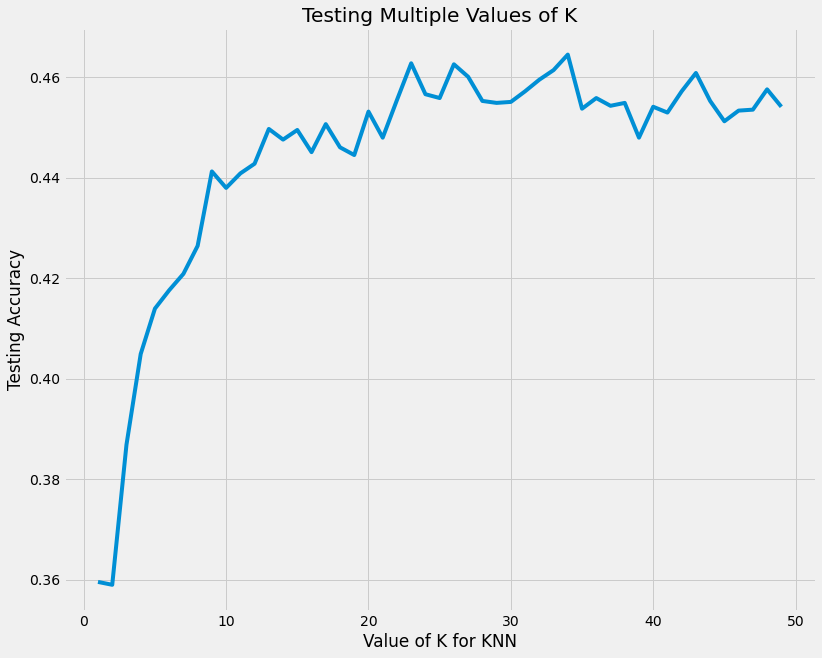

In [22]:
#plot results of k testing
plt.style.use('fivethirtyeight')
plt.figure(num=None, figsize=(12, 10))

plt.plot(k_range, scores_list)
plt.title('Testing Multiple Values of K')
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [23]:
# k somewhere near 40 is best
knn = KNeighborsClassifier(n_neighbors=40)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

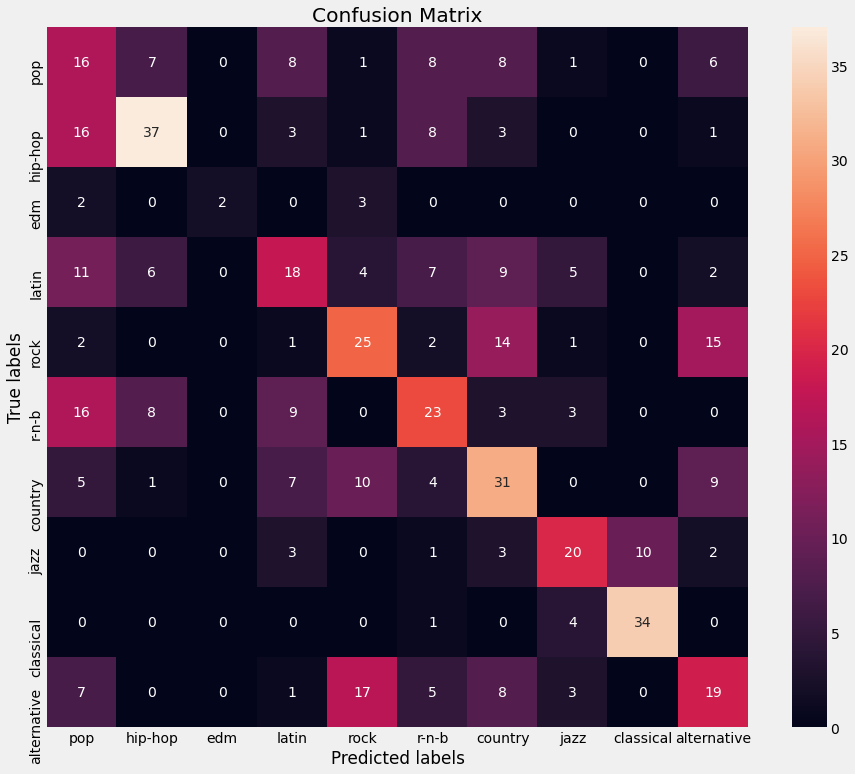

In [24]:
#Create the confusion matrix using test data and predictions
cm = confusion_matrix(y_test, y_pred)
#plot the confusion matrix
plt.figure(figsize=(14, 12))
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)
labels = song_df['genre'].tolist()
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(genres)
ax.yaxis.set_ticklabels(genres)
plt.show()

In [25]:
#Show the accuracy score 
print("Accuracy Score", accuracy_score(y_test, y_pred))

Accuracy Score 0.4326923076923077


In [26]:
knn_classes = knn.predict(playlist_df_ul.values)
print(knn_classes)

[0 7 0 4 5 1 1 6 6 0 5 7 0 1 1 0 3 3 7 3 6 5 6 3 1 0 6 0 4 0 5 1 6 5 6 3 6
 7 0 4 6 6 7 6 7 0 7 0 0 0 0 0 6 7 0 0 5 9 6 6 0 1 3 0 5 0 5 0 5 0 3 0 7 1
 0 6 6 3 1 7 0 0 5 5 6 0 3 0 0 0 5 1 7 6 3 0 1 5 7 8 0 0 0 0 0 0 5 7 0 6 6
 7 5 1 0 0 0 4 6 6 6 5 6 5 0 6 6 0 7 0 7 3 3 6 6 5 6 6 6 7 8 6 6 5 0 7 0 0
 5 6 6 0 4 0 6 0 1 1 2 5 0 5 7 5 6 5 3 0 6 1 0 7 7 8 5 0 1 4 0 8 6 0 7 6 6
 4 0 3 0 0 0 6 5 0 7 9 6 5 0 6 5 7 0 0 7 6 9 6 3 2 4 6 0 6 5 6 6 6 0 0 4 6
 0 0 7 5 7 0 0 1 4 6 0 0 7 0 5 0 0 3 6 1 7 0 7 0 1 6 7 5 7 1 6 0 0 3 0 0 6
 6 7 3 1 0 7 6 6 5 5 0 5 6 5 6 0 0 4 3 0 6 7 5 4 0 6 0 0 7 5 0 6 6 0 6 5 0
 6 2 3 5 5 5 0 8 7 6 9 5 6 0 5 7 0 5 0 1 0 0 1 0 6 5 1 6 6 5 2 4 0 5 6 0 1
 5 5 5 6 3 6 0 6 1 6 1 0 5 6 5 0 0 6 5 5 5 6 0 8 0 0 6 0 8 6 6 5 0 6 6 6 6
 0 7 1 6 6 6 0 6 6 5 0 4 9 6 4 7 8 5 0 5 0 6 1 0 6 0 1 6 6 6 0 5 8 0 6 3 5
 0 0 0 1 3 1 7 0 3 6 0 1 0 0 0 6 3 0 6 5 0 0 1 4 0 5 6 1 3 5 6 1 8 6 0 0 5
 6 0 6 0 6 7 6 4 6 6 7 1 4 0 0 1 6 0 7 6 6 7 6 5 5 5 2 1 7 6 7 0 7 0 3 3 6
 6 5 0 4 1 4 0 0 3 0 0 6 

#### K-Means with PCA

In [66]:
# PCA 
pca = PCA(n_components=2)
pca.fit(song_df_ul.values)
projected_x = pca.transform(song_df_ul.values)
projected_y = pca.transform(playlist_df_ul.values)

In [67]:
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_[:2]))

[0.43317433 0.19674501]
0.6299193420885734


In [68]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(projected_x)
x_labels = kmeans.predict(projected_x)
y_labels = kmeans.predict(projected_y)

Text(0.5, 1.0, '2 Component PCA representation of KNN')

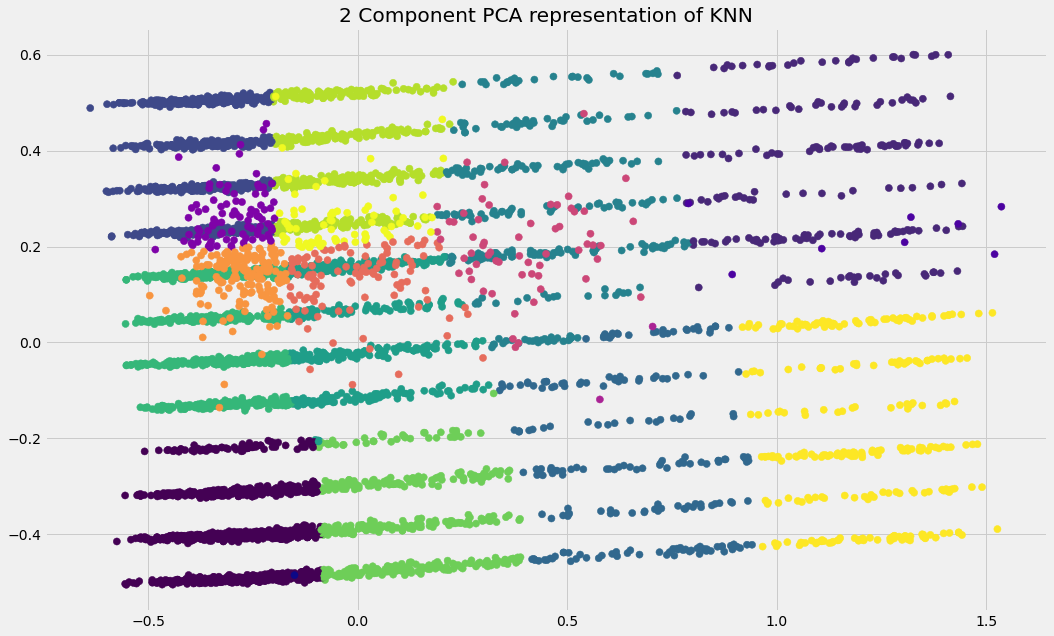

In [84]:
plt.figure(figsize=(16, 10))
plt.scatter(projected_x[:, 0], projected_x[:, 1], c=x_labels, s=50, cmap='viridis')
plt.scatter(projected_y[:, 0], projected_y[:, 1], c=y_labels, s=50, cmap='plasma')
plt.title('2 Component PCA representation of KNN')
# different labels for songs and playlists. 
# playlists are over the top of songs.

#### Neural Network Classification

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, list(y), test_size=0.05, random_state=2)

In [28]:
# using keras create NN
def classification_model():
    #Create the model
    model = Sequential()
    #Add 1 layer with 12 nodes, input of 9 dim with relu function
    model.add(Dense(12, input_dim=9, activation='relu', name='Dense_1'))
    model.add(Dropout(0.1, input_shape=(12,), name='Dropout_1'))
    # Add another layer
    model.add(Dense(24, input_dim=12, activation='relu', name='Dense_2'))
    # dropout layers lets us prevent overfitting
    model.add(Dropout(0.1, input_shape=(24,), name='Dropout_2'))
    # Add another layer
    model.add(Dense(48, input_dim=24, activation='relu', name='Dense_3'))
    # add tanh layer for sigmoid classification if i want to output embeddings
    model.add(Dense(96, input_dim=48, activation='tanh', name='Dense_4'))
    model.add(Dense(10, input_dim=96, activation='softmax', name='Output_Layer'))
    # Compile the model using cat cross ent loss function and adam optimizer with learning rate, 
    # accuracy correspond to the metric displayed
    opt = Adam(learning_rate=0.02)
    loss = CategoricalCrossentropy(label_smoothing=0.2)
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    return model

# define model
classifier = KerasClassifier(build_fn=classification_model, epochs=3000, batch_size=300, verbose=0)

In [29]:
# implement early stopping to prevent epoch maximisation which may lead to overfitting
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=400)
history = classifier.fit(X_train, y_train, validation_split = 0.05, callbacks=[es])

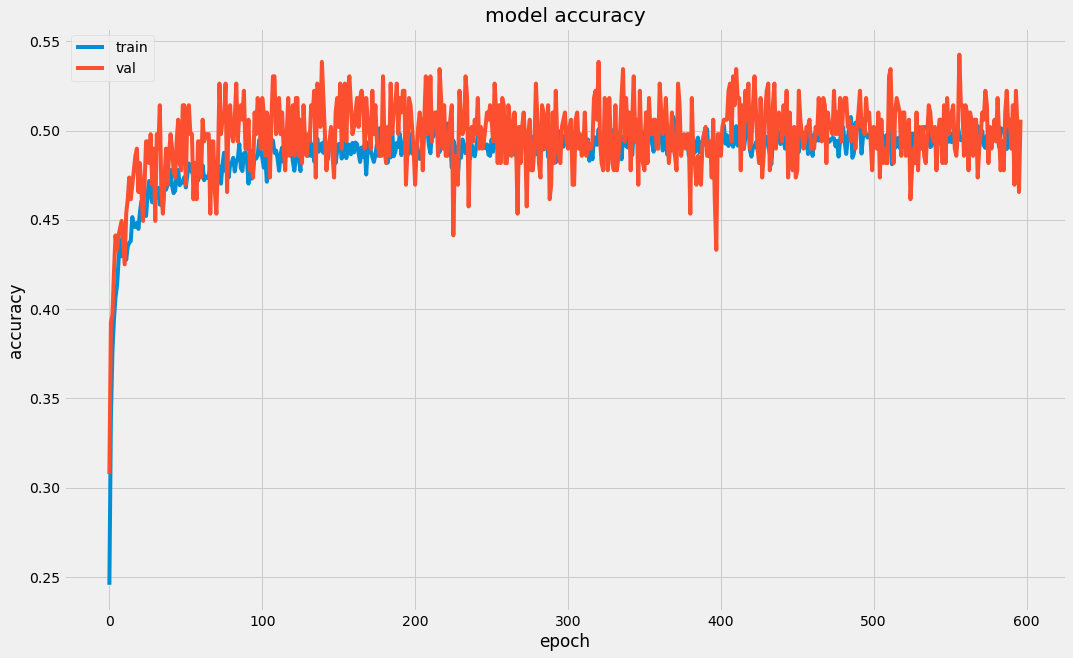

In [30]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

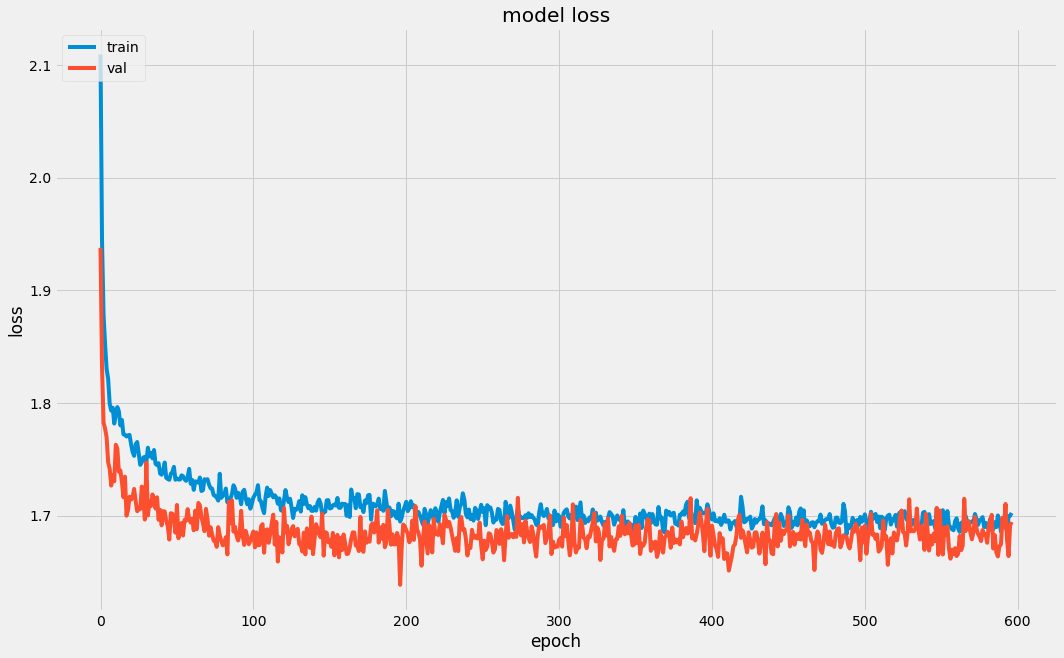

In [31]:
plt.figure(figsize=(16, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
#Train the model with the train data
classifier.fit(X_train, y_train)
#Predict the model with the test data
y_pred = classifier.predict(X_test)

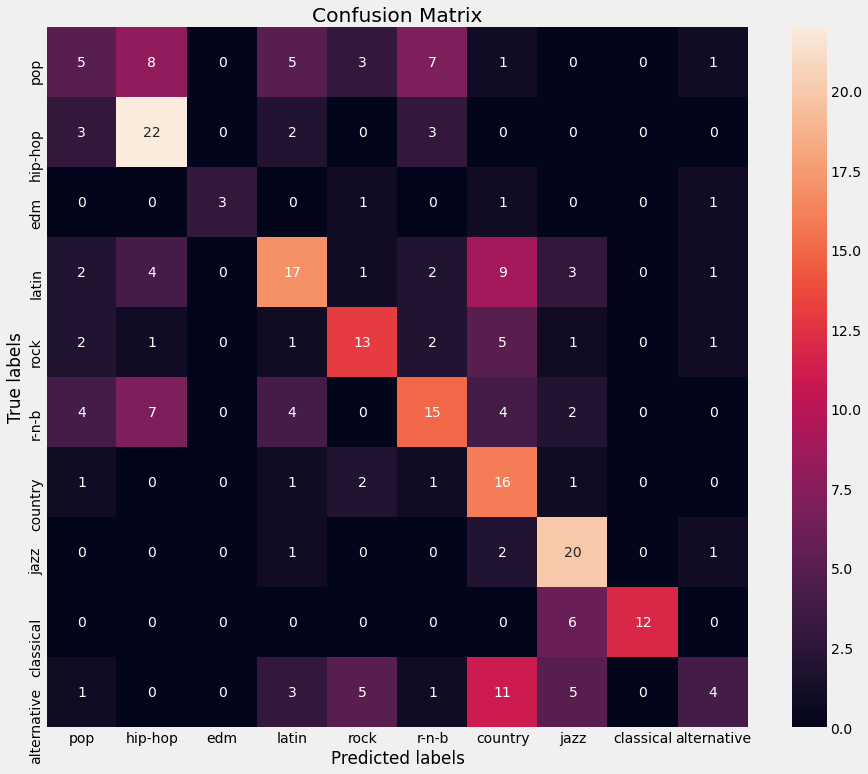

In [33]:
#Create the confusion matrix using test data and predictions
cm = confusion_matrix(y_test, y_pred)
#plot the confusion matrix
plt.figure(figsize=(14, 12))
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)
labels = song_df['genre'].tolist()
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(genres)
ax.yaxis.set_ticklabels(genres)
plt.show()

In [34]:
#Show the accuracy score 
print("Accuracy Score", accuracy_score(y_test, y_pred))

Accuracy Score 0.48659003831417624


In [35]:
# # get tahn layer embedding
# tanh_layer = history.model.layers[5].get_weights()
# # 0 is the weights
# tanh_layer[0]
# tf.print(history.model.layers[5].output)
# relu_layer = history.model.layers[4].get_weights()

In [36]:
def classify_playlist(playlist, KNN=True):
    '''
    chooses which classifier to use (knn or nn)
    '''
    
    if KNN == True:
        playlist_prediction = knn.predict(playlist.reshape(1, -1))
        
    elif KNN == False:
            playlist_prediction = classifier.predict(playlist.reshape(1, 9))
    
    return playlist_prediction


In [175]:
def predict_song(playlist_index, KNN, uri_label, own_playlist):
    
    # if uri is provided
    if own_playlist == True:
        playlist_uris = [i['track']['uri'] for i in sp.playlist(uri_label)['tracks']['items']]
        features = np.array(playlist_summarise(playlist_uris))
        playlist_name = sp.playlist(uri_label)['name']
        print(f'Name of playlist: {playlist_name}')
        playlist_prediction = classify_playlist(features, KNN)
        print(f'The playlist is genre: {genres[playlist_prediction[0]]}')
    
    # if querying playlist from dataset
    else:
        print(f"Name of playlist: {playlists[playlist_index]['name']}")
        features = playlist_df_ul.values[playlist_index]
        playlist_prediction = classify_playlist(features, KNN)
        print(f'The playlist is genre: {genres[playlist_prediction[0]]}')
    
    # generate songs of specific genre
    genre_songs = song_df.loc[song_df['genre'] == playlist_prediction[0]]
    genre_songs = genre_songs.drop(columns = ['genre']).reset_index(drop=True)
        
    # so we take all genre songs we have and gaussian process 
    # fit a Gaussian Mixture Model
    clf = mixture.GaussianMixture(n_components=(len(genre_songs))//n_requests, covariance_type='full', random_state=0)
    clf.fit(genre_songs.drop(columns = ['uri']).values)
    
    # predict classes using GMM
    classes = clf.predict(genre_songs.drop(columns = ['uri']).values)
    
    # recommend top x songs
    most_recommended_songs = clf.predict_proba(features.reshape(1,-1))[0]
    # print(most_recommended_songs)
    max_index, max_value = max(enumerate(most_recommended_songs), key=operator.itemgetter(1))
    
    # take the songs
    songs_index = np.where(classes == max_index)
    selected_songs = genre_songs.loc[songs_index]
    selected_songs_uris = selected_songs['uri'].values
    
    # make sure songs aren't already in playlist
    if own_playlist == False:
        playlist_uris, pid = find_uris(playlists, start=playlist_index-1, SIZE=playlist_index)
        playlist_uris = playlist_uris[0]
    
    # remove overlapping songs
    for element in playlist_uris:
        if element in selected_songs_uris:
            selected_songs_uris.remove(element)
    
    print('\n')
    print('The recommended songs, in no particular order, are:')
    counter = 0
    for i in selected_songs_uris:
        counter +=1
        print(f"{sp.track(i)['name']}, by {sp.track(i)['artists'][0]['name']}")
        if counter == 20:
            break
        
    return

In [38]:
# using NN
predict_song(playlist_index=0,
             KNN=False,
             uri_label='spotify:playlist:1uxYGMdAecU679BHs3TaI7',
             own_playlist=False)


Name of playlist: pump
The playlist is genre: hip-hop


The recommended songs, in no particular order, are:
Glow Like Dat, by Rich Brian
REEL IT IN, by Aminé
Sippin On Some Syrup (feat. UGK (Underground Kingz) & Project Pat), by Three 6 Mafia
U Can't Touch This, by MC Hammer
The Breaks, by Kurtis Blow
Swang, by Rae Sremmurd
I'm N Luv (Wit a Stripper) (feat. Mike Jones), by T-Pain
Collard Greens, by ScHoolboy Q
Ladders, by Mac Miller
D.R.U.G.S., by Ab-Soul
No Rest, by Lil Skies
Day 'N' Nite (nightmare), by Kid Cudi


In [39]:
# using KNN
predict_song(playlist_index=0,
             KNN=True,
             uri_label='spotify:playlist:1uxYGMdAecU679BHs3TaI7',
             own_playlist=False)

Name of playlist: pump
The playlist is genre: pop


The recommended songs, in no particular order, are:
3005, by Childish Gambino
Don't Let Me Down (feat. Daya), by The Chainsmokers
Send My Love (To Your New Lover), by Adele
Heart Attack, by Demi Lovato
Wake Up, by Fetty Wap
We Are Young (feat. Janelle Monáe), by fun.
Stressed Out, by Twenty One Pilots
Someone New, by Hozier
Sucker for Pain (with Wiz Khalifa, Imagine Dragons, Logic & Ty Dolla $ign feat. X Ambassadors), by Lil Wayne
You Da Baddest (feat. Nicki Minaj), by Future
Famous, by Kanye West
Don't Mind, by Kent Jones
Power (feat. Stormzy), by Little Mix
To the Max (feat. Drake), by DJ Khaled
Wet Dreamz, by J. Cole


In [162]:
# using NN predict songs for my own playlist
predict_song(playlist_index=0,
             KNN=False,
             uri_label='spotify:playlist:1uxYGMdAecU679BHs3TaI7',
             own_playlist=True)

100%|██████████| 100/100 [00:04<00:00, 20.91it/s]


Name of playlist: Chill
The playlist is genre: jazz


The recommended songs, in no particular order, are:
Doubts 2, by Ibrahim Maalouf
I Wish I Played Guitar, by Liam Noble
Soar Away, by Dave Douglas
Birth, by Keith Jarrett
Winter, by Mark Isham
She Walked Into My Life, by Joe Albany
Ahmad's Blues, by Ahmad Jamal
Smoke Gets In Your Eyes, by Art Tatum
You Go To My Head, by Art Pepper
Blues Stride, by McCoy Tyner Trio
It Ain’t Necessarily So, by Mary Lou Williams
Swedish Landscape - Live, by Chick Corea
Blackberry Winter, by Keith Jarrett
The Followers, by Pete Oxley
Rhapsody in Blue, by George Gershwin
Stardust, by Gerry Mulligan
Moonlight In Vermont, by Chet Baker
Black Orchid, by Cal Tjader
D-Natural Blues, by Wes Montgomery
I'll Let You Know, by David Hazeltine
Where or When, by Wynton Marsalis
He's Younger Than You Are - From "Alfie" Score, by Sonny Rollins
Requiem, by Lennie Tristano
My Funny Valentine, by Gerry Mulligan


Thanks algorithm!

# CS146

In [40]:
import pystan

#### Multivariate Logistic Regression

In [41]:
target = list(song_df['genre'])

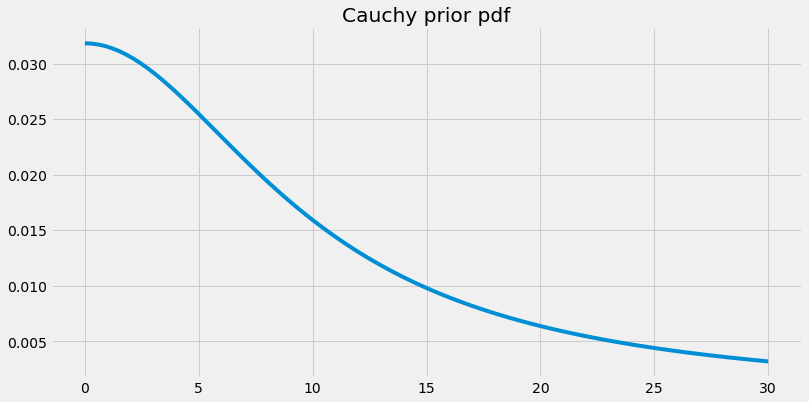

In [160]:
# cauchy prior
# gelman 2008
multiplier_prior = stats.cauchy(loc=0, scale=10)
plt.figure(figsize=(12, 6))
x = np.linspace(0, 30, 100)
plt.plot(x, multiplier_prior.pdf(x))
plt.title("Cauchy prior pdf")
plt.show()

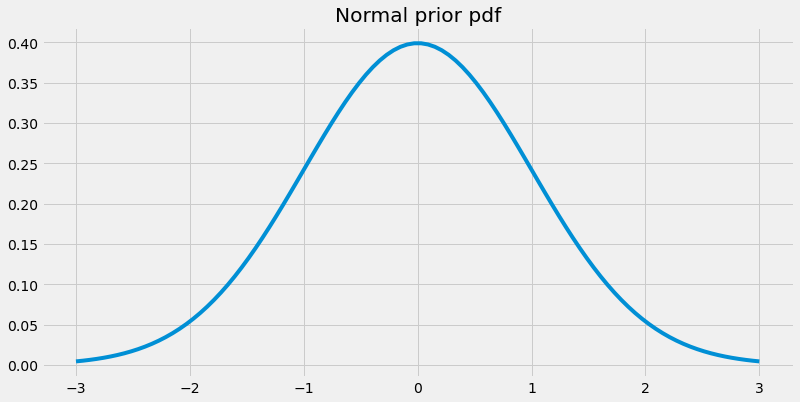

In [44]:
# nromal for beta
multiplier_prior = stats.norm(loc=0, scale=1)
plt.figure(figsize=(12, 6))
x = np.linspace(-3, 3, 100)
plt.plot(x, multiplier_prior.pdf(x))
plt.title("Normal prior pdf")
plt.show()

In [42]:
# data to use in stan model
stan_data = {
    'N': len(song_df_ul), # number of songs
    'N2': len(playlist_df_ul), # number of playlists
    'D': len(song_df_ul.columns), # number of features
    'K': 10, # number of classes
    'y': np.array(target) + 1, # the reponse
    'x': song_df_ul.values, # model matrix
    'x_new': playlist_df_ul.values
}

In [45]:
stan_code = '''

data {
    int<lower=0> N; //the number of training observations
    int<lower=0> N2; //the number of test observations
    int<lower=1> D; //the number of features
    int<lower=2> K; //the number of classes
    int<lower=1, upper=K> y[N]; //the response
    matrix[N, D] x; //the model matrix
    matrix[N2, D] x_new; //the matrix for the predicted values
}

parameters {
    real alpha;
    matrix[D, K] beta; //the regression coefficient matrix
}

model {
    
    matrix[N, K] x_beta = x*beta;
    
    alpha ~ cauchy(0,10); //prior for the intercept following Gelman 2008
    
    to_vector(beta) ~ normal(0, 1); // prior on regression coefficients
    
    // logit output (logistic odds)
    for (n in 1:N) {
        y[n] ~ categorical_logit(x_beta[n]');
    }
}

// predict playlist df
generated quantities {                                                                               
    matrix[N2, K] y_pred;
    for (n in 1:N2) {
        for (k in 1:K) {
            y_pred[n,k] = alpha + x_new[n, ] * beta[, k]; //the y values predicted by the model
        }
        
    }
}


'''

In [46]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_afd5bf0a4896d851b32694f8ef580288 NOW.


In [47]:
results = stan_model.sampling(data=stan_data)
print(results)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_afd5bf0a4896d851b32694f8ef580288.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha           -1.07     1.0  51.28  -81.7  -9.51  -0.33   8.89  73.57   2609    1.0
beta[1,1]       -0.09  9.1e-3   0.33  -0.75  -0.32  -0.09   0.13   0.55   1348    1.0
beta[2,1]       -1.72  9.2e-3   0.39  -2.49   -2.0  -1.72  -1.46  -0.95   1825    1.0
beta[3,1]        3.24  8.7e-3   0.43    2.4   2.96   3.24   3.54   4.06   2383    1.0
beta[4,1]       -0.85  8.6e-3   0.45  -1.72  -1.16  -0.85  -0.55 5.6e-3   2743    1.0
beta[5,1]       -3.12  9.9e-3   0.68   -4.5  -3.56  -3.12  -2.65  -1.83   4751    1.0
beta[6,1]        1.25  9.3e-3    0.5   0.29   0.92   1.26   1.57    2.2   2831    1.0
beta[7,1]        2.75  8.8e-3   0.45   1.89   2.45   2.75   3.05   3.63   2547    1.0
beta[8,1]       -1.57  9.6e-3   0.38 

In [48]:
samples = results.extract()

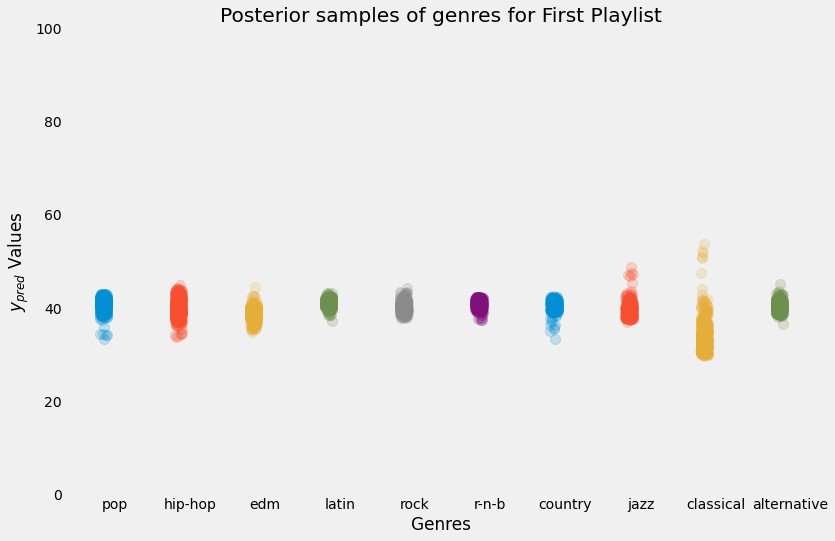

In [158]:
# plotting single playlist samples
plt.figure(figsize=(12,8))
for i in range(10):
    plt.plot(stats.uniform.rvs(loc=i+1-0.2, scale=0.1, size=500), samples['y_pred'][0][:,i], '.', alpha=0.2, markersize=20)
plt.title('Posterior samples of genres for First Playlist')
plt.xticks(range(1, 10+1), genres)
plt.ylim(0, 100)
plt.grid()
plt.xlabel('Genres')
plt.ylabel('$y_{pred}$ Values')
plt.show()

In [49]:
# average over all y_preds for each row of playlist df
target = np.mean(samples['y_pred'], axis=0)  

In [50]:
# reminder of genres
genres = ['pop', 'hip-hop', 'edm', 'latin', 'rock',
          'r-n-b', 'country', 'jazz', 'classical',
          'alternative']

Turn natural logarithm of the odds, known as the logit, into probabilities

In [51]:
def logitodds_to_probs(odds):
    '''
    take exponent and divide over sum
    '''
    return np.exp(odds) / np.sum(np.exp(odds))

In [52]:
def most_likely(probs):
    '''
    use argmax to find highest probability genre
    '''
    max_prob = np.argmax(probs)
    return max_prob

In [53]:
# append highest probability songs using functions above
blr_classes = []
for i in target:
    probs = logitodds_to_probs(i)
    classification = most_likely(probs)
    blr_classes.append(classification)

In [54]:
print(blr_classes)

[1, 7, 0, 4, 3, 1, 1, 9, 6, 1, 3, 6, 0, 1, 1, 1, 3, 3, 7, 3, 6, 0, 6, 3, 1, 3, 3, 0, 9, 0, 6, 1, 6, 3, 9, 0, 6, 7, 1, 4, 3, 6, 7, 3, 3, 0, 7, 9, 1, 9, 0, 0, 6, 7, 0, 0, 5, 4, 6, 3, 1, 1, 3, 6, 3, 1, 3, 0, 9, 0, 3, 0, 7, 1, 9, 9, 6, 0, 1, 7, 9, 0, 1, 3, 3, 6, 1, 1, 0, 3, 1, 0, 7, 6, 3, 6, 1, 1, 3, 8, 1, 1, 1, 1, 0, 0, 3, 7, 0, 3, 6, 3, 1, 1, 0, 0, 6, 4, 6, 3, 9, 1, 6, 3, 0, 3, 6, 9, 7, 1, 7, 3, 3, 5, 7, 0, 6, 3, 3, 3, 8, 6, 6, 1, 0, 7, 3, 1, 7, 6, 6, 6, 9, 0, 6, 0, 1, 1, 9, 1, 3, 5, 7, 0, 3, 1, 1, 9, 6, 1, 1, 5, 6, 8, 3, 3, 1, 9, 0, 8, 0, 9, 7, 7, 6, 3, 9, 3, 1, 3, 0, 6, 3, 9, 7, 9, 4, 5, 0, 0, 9, 3, 1, 1, 5, 6, 9, 6, 3, 2, 3, 4, 0, 4, 6, 3, 9, 6, 0, 0, 4, 9, 0, 1, 3, 0, 7, 0, 0, 1, 4, 9, 1, 0, 7, 1, 6, 0, 0, 3, 3, 1, 7, 0, 7, 0, 1, 6, 7, 3, 7, 1, 4, 0, 0, 3, 0, 0, 4, 3, 7, 3, 1, 1, 7, 6, 3, 0, 1, 0, 3, 6, 3, 6, 0, 9, 4, 3, 0, 6, 3, 6, 4, 3, 6, 1, 0, 7, 7, 0, 6, 6, 0, 6, 3, 0, 7, 2, 3, 1, 6, 5, 1, 8, 7, 6, 9, 6, 3, 0, 1, 7, 1, 9, 0, 1, 0, 3, 1, 0, 3, 6, 1, 3, 3, 5, 9, 4, 0, 0, 3, 0, 1, 

In [176]:
def predict_song_blr(class_array, index):
    '''
    predict the next best songs 
    using the bayesian logistic regression output
    we input the index of the song we want to predict
    and the whole classification array
    
    we use a GMM here as well
    '''
    
    print(f"Name of playlist: {playlists[index]['name']}")
    features = playlist_df_ul.values[index]
    print(f'The playlist is genre: {genres[class_array[index]]}')
    
    genre_songs = song_df.loc[song_df['genre'] == class_array[index]]
    genre_songs = genre_songs.drop(columns = ['genre']).reset_index(drop=True)
        
    # so we take all genre songs we have and gaussian process 
    # fit a Gaussian Mixture Model
    clf = mixture.GaussianMixture(n_components=(len(genre_songs))//n_requests, covariance_type='full', random_state=0)
    clf.fit(genre_songs.drop(columns = ['uri']).values)
    
    classes = clf.predict(genre_songs.drop(columns = ['uri']).values)
    
    # recommend top x songs
    most_recommended_songs = clf.predict_proba(features.reshape(1,-1))[0]
    # print(most_recommended_songs)
    max_index, max_value = max(enumerate(most_recommended_songs), key=operator.itemgetter(1))
    
    # take the songs
    songs_index = np.where(classes == max_index)
    selected_songs = genre_songs.loc[songs_index]
    selected_songs_uris = selected_songs['uri'].values
    
    # make sure songs aren't already in playlist
    playlist_uris, pid = find_uris(playlists, start=index-1, SIZE=index)
    playlist_uris = playlist_uris[0]
    
    # remove overlapping songs
    for element in playlist_uris:
        if element in selected_songs_uris:
            selected_songs_uris.remove(element)
    
    print('\n')
    print('The recommended songs, in no particular order, are:')
    counter = 0
    for i in selected_songs_uris:
        counter += 1
        print(f"{sp.track(i)['name']}, by {sp.track(i)['artists'][0]['name']}")
        if counter == 20:
            break
        
    return

In [56]:
predict_song_blr(blr_classes, index=0)

Name of playlist: pump
The playlist is genre: hip-hop


The recommended songs, in no particular order, are:
Glow Like Dat, by Rich Brian
REEL IT IN, by Aminé
Sippin On Some Syrup (feat. UGK (Underground Kingz) & Project Pat), by Three 6 Mafia
U Can't Touch This, by MC Hammer
The Breaks, by Kurtis Blow
Swang, by Rae Sremmurd
I'm N Luv (Wit a Stripper) (feat. Mike Jones), by T-Pain
Collard Greens, by ScHoolboy Q
Ladders, by Mac Miller
D.R.U.G.S., by Ab-Soul
No Rest, by Lil Skies
Day 'N' Nite (nightmare), by Kid Cudi


In [88]:
predict_song_blr(blr_classes, index=401)

Name of playlist: Together
The playlist is genre: pop


The recommended songs, in no particular order, are:
You & Me - Flume Remix, by Disclosure
Let Her Go, by Passenger
Hear Me Now, by Alok
Crush, by Yuna
Controlla, by Drake
7 Years, by Lukas Graham
See You Again (feat. Charlie Puth), by Wiz Khalifa
Come and See Me (feat. Drake), by PARTYNEXTDOOR
Psycho (feat. Ty Dolla $ign), by Post Malone
Say It, by Tory Lanez
Don't, by Bryson Tiller
Plug Walk, by Rich The Kid
Cool Girl, by Tove Lo
Lucid Dreams, by Juice WRLD
Weekend (feat. Miguel), by Mac Miller
Homemade Dynamite, by Lorde
Don’t Matter To Me (with Michael Jackson), by Drake


### Comparing results of KNN/NN/Bayesian Logistic Regression

In [57]:
# knn
print(list(knn_classes))

[0, 7, 0, 4, 5, 1, 1, 6, 6, 0, 5, 7, 0, 1, 1, 0, 3, 3, 7, 3, 6, 5, 6, 3, 1, 0, 6, 0, 4, 0, 5, 1, 6, 5, 6, 3, 6, 7, 0, 4, 6, 6, 7, 6, 7, 0, 7, 0, 0, 0, 0, 0, 6, 7, 0, 0, 5, 9, 6, 6, 0, 1, 3, 0, 5, 0, 5, 0, 5, 0, 3, 0, 7, 1, 0, 6, 6, 3, 1, 7, 0, 0, 5, 5, 6, 0, 3, 0, 0, 0, 5, 1, 7, 6, 3, 0, 1, 5, 7, 8, 0, 0, 0, 0, 0, 0, 5, 7, 0, 6, 6, 7, 5, 1, 0, 0, 0, 4, 6, 6, 6, 5, 6, 5, 0, 6, 6, 0, 7, 0, 7, 3, 3, 6, 6, 5, 6, 6, 6, 7, 8, 6, 6, 5, 0, 7, 0, 0, 5, 6, 6, 0, 4, 0, 6, 0, 1, 1, 2, 5, 0, 5, 7, 5, 6, 5, 3, 0, 6, 1, 0, 7, 7, 8, 5, 0, 1, 4, 0, 8, 6, 0, 7, 6, 6, 4, 0, 3, 0, 0, 0, 6, 5, 0, 7, 9, 6, 5, 0, 6, 5, 7, 0, 0, 7, 6, 9, 6, 3, 2, 4, 6, 0, 6, 5, 6, 6, 6, 0, 0, 4, 6, 0, 0, 7, 5, 7, 0, 0, 1, 4, 6, 0, 0, 7, 0, 5, 0, 0, 3, 6, 1, 7, 0, 7, 0, 1, 6, 7, 5, 7, 1, 6, 0, 0, 3, 0, 0, 6, 6, 7, 3, 1, 0, 7, 6, 6, 5, 5, 0, 5, 6, 5, 6, 0, 0, 4, 3, 0, 6, 7, 5, 4, 0, 6, 0, 0, 7, 5, 0, 6, 6, 0, 6, 5, 0, 6, 2, 3, 5, 5, 5, 0, 8, 7, 6, 9, 5, 6, 0, 5, 7, 0, 5, 0, 1, 0, 0, 1, 0, 6, 5, 1, 6, 6, 5, 2, 4, 0, 5, 6, 0, 1, 

In [58]:
# NN
nn_classes = classifier.predict(playlist_df_ul.values)
print(list(nn_classes))

[1, 7, 0, 4, 4, 1, 1, 7, 6, 1, 4, 7, 0, 1, 1, 1, 3, 3, 7, 3, 6, 0, 6, 7, 1, 0, 6, 0, 2, 0, 6, 1, 6, 3, 7, 3, 7, 7, 3, 4, 4, 6, 7, 4, 7, 2, 7, 4, 1, 0, 3, 0, 6, 7, 0, 0, 1, 4, 4, 6, 1, 1, 6, 9, 6, 1, 6, 6, 4, 0, 3, 3, 7, 1, 9, 7, 7, 0, 1, 7, 0, 5, 0, 7, 7, 6, 1, 2, 0, 0, 0, 0, 7, 4, 3, 0, 1, 5, 7, 8, 1, 0, 1, 2, 5, 2, 6, 7, 3, 6, 6, 7, 1, 1, 0, 0, 0, 4, 6, 7, 6, 1, 6, 6, 0, 7, 7, 0, 7, 1, 7, 3, 3, 7, 7, 0, 6, 5, 4, 7, 8, 4, 6, 0, 2, 7, 3, 2, 7, 6, 4, 6, 7, 0, 6, 0, 1, 1, 2, 1, 3, 5, 7, 5, 4, 1, 2, 2, 6, 1, 1, 7, 7, 7, 3, 3, 1, 7, 0, 8, 6, 9, 7, 7, 6, 7, 2, 3, 1, 0, 5, 6, 6, 6, 7, 4, 6, 6, 0, 0, 4, 7, 1, 1, 4, 6, 9, 4, 3, 2, 7, 0, 0, 6, 6, 4, 6, 6, 6, 0, 4, 4, 3, 1, 7, 0, 7, 0, 2, 1, 4, 7, 0, 0, 7, 1, 6, 0, 0, 3, 7, 1, 7, 3, 7, 0, 1, 6, 7, 6, 7, 1, 6, 3, 1, 3, 3, 0, 7, 4, 7, 3, 1, 1, 7, 6, 6, 9, 1, 1, 5, 6, 7, 6, 0, 9, 4, 3, 3, 6, 7, 6, 4, 3, 6, 1, 5, 7, 7, 3, 6, 6, 0, 7, 3, 3, 7, 2, 3, 1, 7, 5, 1, 8, 7, 6, 4, 6, 0, 3, 1, 7, 1, 4, 0, 1, 0, 3, 1, 5, 4, 6, 1, 0, 6, 5, 2, 4, 2, 3, 6, 0, 1, 

In [59]:
# bayesian logistic regression
print(blr_classes)

[1, 7, 0, 4, 3, 1, 1, 9, 6, 1, 3, 6, 0, 1, 1, 1, 3, 3, 7, 3, 6, 0, 6, 3, 1, 3, 3, 0, 9, 0, 6, 1, 6, 3, 9, 0, 6, 7, 1, 4, 3, 6, 7, 3, 3, 0, 7, 9, 1, 9, 0, 0, 6, 7, 0, 0, 5, 4, 6, 3, 1, 1, 3, 6, 3, 1, 3, 0, 9, 0, 3, 0, 7, 1, 9, 9, 6, 0, 1, 7, 9, 0, 1, 3, 3, 6, 1, 1, 0, 3, 1, 0, 7, 6, 3, 6, 1, 1, 3, 8, 1, 1, 1, 1, 0, 0, 3, 7, 0, 3, 6, 3, 1, 1, 0, 0, 6, 4, 6, 3, 9, 1, 6, 3, 0, 3, 6, 9, 7, 1, 7, 3, 3, 5, 7, 0, 6, 3, 3, 3, 8, 6, 6, 1, 0, 7, 3, 1, 7, 6, 6, 6, 9, 0, 6, 0, 1, 1, 9, 1, 3, 5, 7, 0, 3, 1, 1, 9, 6, 1, 1, 5, 6, 8, 3, 3, 1, 9, 0, 8, 0, 9, 7, 7, 6, 3, 9, 3, 1, 3, 0, 6, 3, 9, 7, 9, 4, 5, 0, 0, 9, 3, 1, 1, 5, 6, 9, 6, 3, 2, 3, 4, 0, 4, 6, 3, 9, 6, 0, 0, 4, 9, 0, 1, 3, 0, 7, 0, 0, 1, 4, 9, 1, 0, 7, 1, 6, 0, 0, 3, 3, 1, 7, 0, 7, 0, 1, 6, 7, 3, 7, 1, 4, 0, 0, 3, 0, 0, 4, 3, 7, 3, 1, 1, 7, 6, 3, 0, 1, 0, 3, 6, 3, 6, 0, 9, 4, 3, 0, 6, 3, 6, 4, 3, 6, 1, 0, 7, 7, 0, 6, 6, 0, 6, 3, 0, 7, 2, 3, 1, 6, 5, 1, 8, 7, 6, 9, 6, 3, 0, 1, 7, 1, 9, 0, 1, 0, 3, 1, 0, 3, 6, 1, 3, 3, 5, 9, 4, 0, 0, 3, 0, 1, 

In [60]:
def compare_three(one, two, three):
    '''
    compare all 3 classifications
    '''
    similarity_list = np.zeros(len(one))
    for i in range(len(one)):
        if one[i] == two[i] == three[i]:
            similarity_list[i] = 1
    return similarity_list

In [61]:
def compare_two(one, two):
    '''
    compare 2 classifications
    '''
    similarity_list = np.zeros(len(one))
    for i in range(len(one)):
        if one[i] == two[i]:
            similarity_list[i] = 1
    return similarity_list

In [184]:
# how similar are all three predictions?
similarity_list = compare_three(knn_classes, nn_classes, blr_classes)
print(np.mean(similarity_list))

0.404


In [63]:
# how similar are knn and nn?
similarity_list = compare_two(knn_classes, nn_classes)
print(np.mean(similarity_list))

0.504


In [64]:
# how similar are knn and blr?
similarity_list = compare_two(knn_classes, blr_classes)
print(np.mean(similarity_list))

0.542


In [65]:
# how similar are nn and blr?
similarity_list = compare_two(nn_classes, blr_classes)
print(np.mean(similarity_list))

0.586


---

## More Predictions!

Neural Network

In [166]:
predict_song(playlist_index=0,
             KNN=False,
             uri_label='spotify:playlist:0BBs4MfHenleBNn7dY1gkg',
             own_playlist=True)

100%|██████████| 23/23 [00:01<00:00, 21.20it/s]


Name of playlist: Berlini
The playlist is genre: jazz


The recommended songs, in no particular order, are:
Doubts 2, by Ibrahim Maalouf
I Wish I Played Guitar, by Liam Noble
Soar Away, by Dave Douglas
Birth, by Keith Jarrett
Winter, by Mark Isham
She Walked Into My Life, by Joe Albany
Ahmad's Blues, by Ahmad Jamal
Smoke Gets In Your Eyes, by Art Tatum
You Go To My Head, by Art Pepper
Blues Stride, by McCoy Tyner Trio
It Ain’t Necessarily So, by Mary Lou Williams
Swedish Landscape - Live, by Chick Corea
Blackberry Winter, by Keith Jarrett
The Followers, by Pete Oxley
Rhapsody in Blue, by George Gershwin
Stardust, by Gerry Mulligan
Moonlight In Vermont, by Chet Baker
Black Orchid, by Cal Tjader
D-Natural Blues, by Wes Montgomery
I'll Let You Know, by David Hazeltine
Where or When, by Wynton Marsalis
He's Younger Than You Are - From "Alfie" Score, by Sonny Rollins
Requiem, by Lennie Tristano
My Funny Valentine, by Gerry Mulligan


In [169]:
predict_song(playlist_index=0,
             KNN=False,
             uri_label='spotify:playlist:2fNPKQmw2gEE1VPHxx3mvz',
             own_playlist=True)

100%|██████████| 5/5 [00:00<00:00, 22.51it/s]


Name of playlist: Guitar
The playlist is genre: jazz


The recommended songs, in no particular order, are:
Doubts 2, by Ibrahim Maalouf
I Wish I Played Guitar, by Liam Noble
Soar Away, by Dave Douglas
Birth, by Keith Jarrett
Winter, by Mark Isham
She Walked Into My Life, by Joe Albany
Ahmad's Blues, by Ahmad Jamal
Smoke Gets In Your Eyes, by Art Tatum
You Go To My Head, by Art Pepper
Blues Stride, by McCoy Tyner Trio
It Ain’t Necessarily So, by Mary Lou Williams
Swedish Landscape - Live, by Chick Corea
Blackberry Winter, by Keith Jarrett
The Followers, by Pete Oxley
Rhapsody in Blue, by George Gershwin
Stardust, by Gerry Mulligan
Moonlight In Vermont, by Chet Baker
Black Orchid, by Cal Tjader
D-Natural Blues, by Wes Montgomery
I'll Let You Know, by David Hazeltine
Where or When, by Wynton Marsalis
He's Younger Than You Are - From "Alfie" Score, by Sonny Rollins
Requiem, by Lennie Tristano
My Funny Valentine, by Gerry Mulligan


KNN

In [177]:
predict_song(playlist_index=0,
             KNN=True,
             uri_label='spotify:playlist:37i9dQZF1EMcPyMKnRU49D',
             own_playlist=True)

100%|██████████| 100/100 [00:09<00:00, 10.43it/s]


Name of playlist: Your Top Songs 2020
The playlist is genre: rock


The recommended songs, in no particular order, are:
Go To War, by Nothing More
Jenny, by Nothing More
Alive - Chris Lord-Alge Mix, by P.O.D.
Semi-Charmed Life, by Third Eye Blind
Attack, by Thirty Seconds To Mars
You're Gonna Go Far, Kid, by The Offspring
Hard Times, by Paramore
Bitch Came Back, by Theory of a Deadman
Should I Stay or Should I Go - Remastered, by The Clash
Times Like These, by Foo Fighters
Misery, by blink-182
Feels Like Summer, by Weezer
Otherside, by Red Hot Chili Peppers
Who Do You Trust?, by Papa Roach
Know Your Enemy, by Rage Against The Machine
Born in the U.S.A., by Bruce Springsteen
Beautiful Day, by U2
Angel, by Theory of a Deadman
You're Going Down, by Sick Puppies
You Don't Get Me High Anymore, by Three Days Grace


In [187]:
predict_song(playlist_index=57,
             KNN=True,
             uri_label='spotify:playlist:37i9dQZF1EMcPyMKnRU49D',
             own_playlist=False)

Name of playlist: My Chemical Romance
The playlist is genre: alternative


The recommended songs, in no particular order, are:
Machinehead, by Bush
Decode - Twilight Soundtrack Version, by Paramore
When The Sun Goes Down, by Arctic Monkeys
Go With The Flow, by Queens of the Stone Age
Kings And Queens, by Thirty Seconds To Mars
Wolf Like Me, by TV On The Radio
I Can Make You Love Me, by British India
She's Long Gone, by The Black Keys
Moth Wings, by Pond
Vasoline, by Stone Temple Pilots
Knights of Cydonia, by Muse
Walk, by Foo Fighters
Iris, by The Goo Goo Dolls
I Wanna Get Better, by Bleachers
Supremacy, by Muse
Echoes, by Klaxons


BLR

In [178]:
predict_song_blr(blr_classes, index=499)

Name of playlist: JAMS
The playlist is genre: rock


The recommended songs, in no particular order, are:
Barracuda, by Heart
Enter Sandman, by Metallica
Raining, by The Front Bottoms
Summer Of '69, by Bryan Adams
Cat Scratch Fever, by Ted Nugent
Sultans of Swing, by Dire Straits
Gimme All Your Lovin', by ZZ Top
Run To You, by Bryan Adams
High Hopes, by Panic! At The Disco
Up Down (feat. Florida Georgia Line), by Morgan Wallen
Sweet Child O' Mine, by Guns N' Roses
Highway Tune, by Greta Van Fleet
I Was Made For Lovin' You, by KISS
Bleed It Out, by Linkin Park
Pumped Up Kicks, by Foster The People
Black Smoke Rising, by Greta Van Fleet
Hellfire, by Barns Courtney
Start Me Up - Remastered, by The Rolling Stones
Hail to the King, by Avenged Sevenfold


In [181]:
predict_song_blr(blr_classes, index=5)

Name of playlist: logic
The playlist is genre: hip-hop


The recommended songs, in no particular order, are:
Blueberry Yum Yum, by Ludacris
The Game & Skrillex: El Chapo, by The Game
1942 (feat. Yo Gotti & YBN Nahmir), by G-Eazy
New Patek, by Lil Uzi Vert
2 Phones, by Kevin Gates
You Da Baddest (feat. Nicki Minaj), by Future
One Day, by UGK
Hit, by NAV
Still Tippin' (feat. Slim Thug and Paul Wall), by Mike Jones
Who Want The Smoke? (feat. Cardi B & Offset), by Lil Yachty
Good Drank, by 2 Chainz


In [183]:
predict_song_blr(blr_classes, index=12)

Name of playlist: GIRL POWER
The playlist is genre: pop


The recommended songs, in no particular order, are:
Fake Love, by Drake
Firework, by Katy Perry
Trap Queen, by Fetty Wap
Saved, by Khalid
Now and Later, by Sage The Gemini
Creep On Me, by GASHI
That's My Girl, by Fifth Harmony
Happy - From "Despicable Me 2", by Pharrell Williams
Look Alive (feat. Drake), by BlocBoy JB
Am I Wrong, by Nico & Vinz
No Promises (feat. Demi Lovato), by Cheat Codes
F*ck Up Some Commas, by Future
Call Me, by NEIKED
everytime, by Ariana Grande
Ruin My Life, by Zara Larsson
7/11, by Beyoncé
Roll In Peace (feat. XXXTENTACION), by Kodak Black
Woman Like Me (feat. Nicki Minaj), by Little Mix
Wavy (feat. Joe Moses), by Ty Dolla $ign
Either Way (feat. Joey Bada$$), by Snakehips
